In [2]:
from pythtb_Wannier import *
from pythtb import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy

In [3]:
delta = 1
t0 = 0.2
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

# adding disorder
# J = 2
# J_site = 2
# model.set_onsite(J, ind_i = J_site, mode='add')

# model.display()

In [4]:
# 2D k-mesh
nkx = 24
nky = 24
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

In [5]:
u_wfs_full = wf_array(model, [nkx, nky])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print("Chern number: ", chern)

Chern number:  9.718361526694079e-17


In [6]:
u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

In [7]:
low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

switch_rep = False
omit = False
omit_site = 4
compact_SVD = False

if omit:
    tf_list = list(np.setdiff1d(low_E_sites, [omit_site])) # delta on lower energy sites omitting the last site
    tf_list_highE = list(high_E_sites[:]) # delta on high energy sites
else:
    tf_list = list(low_E_sites[:]) # delta on lower energy sites
    tf_list_highE = list(high_E_sites[:]) # delta on high energy sites

n_tfs = len(tf_list)

In [8]:
w0 = Wannierize(
    model, u_wfs_Wan, tf_list, 
    switch_rep=switch_rep, tfs_swap=tf_list_highE, compact_SVD=compact_SVD
    )

In [8]:
u_wfs = np.array(u_wfs_Wan._wfs)
psi_wfs = get_bloch_wfs(model, u_wfs_Wan, k_mesh_flat)
psi_tilde = get_psi_tilde(psi_wfs, tf_list)
u_tilde = get_bloch_wfs(model, psi_tilde, k_mesh_flat, inverse=True)

tfs = set_trial_function(tf_list, n_orb)
state_idx = list(range(0, int(n_orb/2))) # assuming we are Wannierizing occupied bands (half filled)
A = tf_overlap_mat(psi_wfs, tfs, state_idx)
V, S, Wh = SVD(A, full_matrices=False, compact_SVD=compact_SVD)

### K-space path

In [9]:
# generate k-point path and labels
nk = 101
path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
(k_vec, k_dist, k_node) = model.k_path(path, nk, report=False)

In [10]:
phases = get_orb_phases(model, k_vec, inverse=False)#.reshape(*nks, norb) 
tfs_lowE = set_trial_function(tf_list, n_orb)
tfs_highE = set_trial_function(tf_list_highE, n_orb)

A_path = np.zeros((nk, n_occ, n_tfs), dtype=complex)
# SVD
V_path = np.zeros((nk, n_occ, n_tfs), dtype=complex)
S_path = np.zeros((nk, n_tfs))
Wh_path = np.zeros((nk, len(tf_list), len(tf_list)), dtype=complex)
# polar
U_path = np.zeros((nk, n_occ, n_tfs), dtype=complex)
P_path = np.zeros((nk, n_tfs, n_tfs), dtype=complex)

wfs_1d = wf_array(model, [nk])
for k in range(nk):
    wfs_1d.solve_on_one_point([k_vec[k,0], k_vec[k,1]], [k])
    psi_wf = np.array(wfs_1d[k]*phases[k])
    # constructing A
    for m in range(n_occ):
        for n in range(len(tf_list)):
            if switch_rep and m==3 and (k == 0 or k == nk-1):
                # A_path[k, m, n] = psi_wf[n_occ, :].conj() @ tfs_highE[n, :].T 
                A_path[k, m, n] = psi_wf[n_occ, :].conj() @ tfs_lowE[n, :].T 
            else:
                A_path[k, m, n] = psi_wf[m, :].conj() @ tfs_lowE[n, :].T 

    # Polar decomposition (equivalent)
    U_path[k, :], P_path[k, :] = scipy.linalg.polar(A_path[k])

    # SVD
    V_path[k, :, :], S_path[k, :], Wh_path[k, :, :] = np.linalg.svd(A_path[k], full_matrices=False)

In [11]:
compact_SVD = True

In [12]:
if compact_SVD:
    V_path = V_path[..., :, :-1]
    S_path = S_path[..., :-1]
    Wh_path = Wh_path[..., :-1, :]

### Full k-space

In [13]:
k_full = gen_k_mesh(nkx, nky, flat=True, endpoint=True)
phases = get_orb_phases(model, k_full, inverse=False).reshape(nkx, nky, n_orb) 
tfs_lowE = set_trial_function(tf_list, model.get_num_orbitals())
tfs_highE = set_trial_function(tf_list_highE, model.get_num_orbitals())

Nk = nkx*nky
A = np.zeros((nkx, nky, n_occ, len(tf_list)), dtype=complex)
V = np.zeros((nkx, nky, n_occ, len(tf_list)), dtype=complex)
S = np.zeros((nkx, nky, len(tf_list)))
Wh = np.zeros((nkx, nky, len(tf_list), len(tf_list)), dtype=complex)

for kx in range(nkx):
    for ky in range(nky):
        # wfs_full.solve_on_one_point([k_full[kx, ky, 0], k_full[kx, ky, 1]], [kx, ky])
        psi_wf_full = np.array(u_wfs_full[kx, ky]*phases[kx, ky])
        # constructing A
        for m in range(n_occ):
            for n in range(len(tf_list)):
                if switch_rep and m==3 and (k == 0 or k == nk-1):
                    # A[kx, ky, m, n] = psi_wf_full[m, :].conj() @ tfs_highE[n, :].T 
                    A[kx, ky, m, n] = psi_wf_full[n_occ, :].conj() @ tfs_lowE[n, :].T 
                else:
                    A[kx, ky, m, n] = psi_wf_full[m, :].conj() @ tfs_lowE[n, :].T 
        # SVD
        # v, s, wh = np.linalg.svd(A[kx, ky], full_matrices=False)
        # print(np.allclose(np.eye(v.shape[0]), ((v @ wh) @ (v @ wh).conj().T).round(5)  ))
        # print(A.shape[2:], v.shape, s.shape, wh.shape)
        # print(np.allclose(A[kx, ky], a @ (np.diag(b) @ c)))
        V[kx, ky, :, :], S[kx, ky, :], Wh[kx, ky, :, :] = np.linalg.svd(A[kx, ky], full_matrices=False)

### Plotting along path

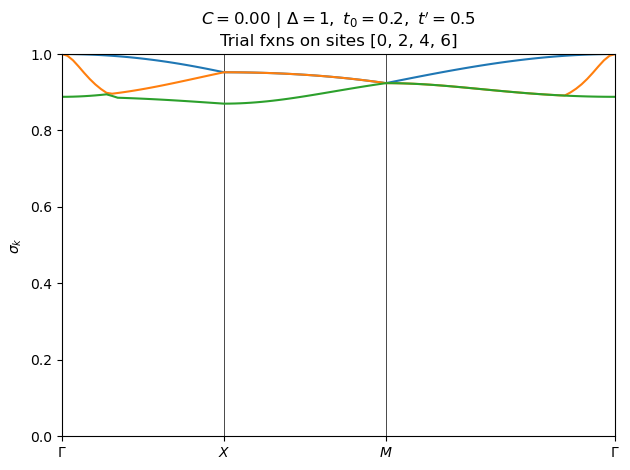

In [14]:
fig, ax = plt.subplots()

label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
ax.set_xlim(0,k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

for n in range(S_path.shape[1]):
  ax.plot(k_dist, S_path[:, n])

ax.set_title(fr"$C = {chern: .2f}$, $\Delta = {delta}$, $t_0= {t0: .2f}, t' = {tprime: .2f}$")
ax.set_title( rf"$C = {chern: .2f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$" 
             "\n"
             rf"Trial fxns on sites {tf_list}"  
             )
# ax.set_xlabel("Path in k-space")
ax.set_ylabel(r"$\sigma_k$")
ax.set_ylim(0,1)
fig.tight_layout()
# plt.savefig(f'singvals_C={chern:.1f}_Delta={delta}_t0={t0}_tp={tprime}_tfxs={tf_list}.png')

### Plotting det(S) over full BZ

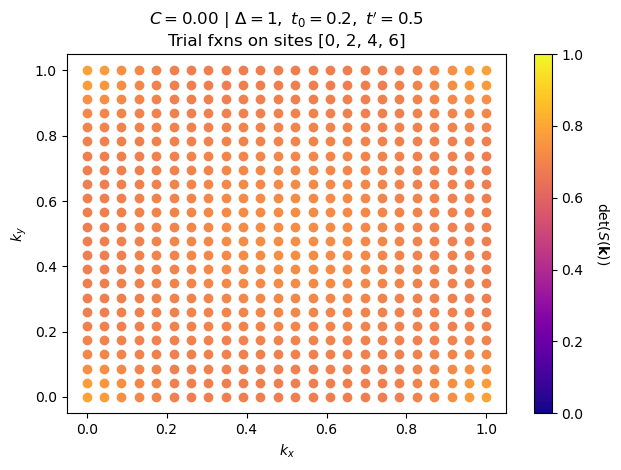

In [15]:
fig, ax = plt.subplots()

k_full_grid = gen_k_mesh(nkx, nky, flat=False, endpoint=True)

for kx in range(nkx):
  for ky in range(nky):
    col = np.prod(S[kx, ky, :])
    scat = plt.scatter(k_full_grid[kx, ky, 0], k_full_grid[kx, ky, 1], c=col, cmap='plasma', vmin=0, vmax=1)

ax.set_title(fr"$C = {chern: .2f}$, $\Delta = {delta}$, $t_0= {t0: .2f}, t' = {tprime: .2f}$")
ax.set_title( rf"$C = {chern: .2f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$" 
             "\n"
             rf"Trial fxns on sites {tf_list}"  
             )
ax.set_xlabel(r"$k_x$")
ax.set_ylabel(r"$k_y$")
cbar = fig.colorbar(scat)
cbar.set_label(r"det($S(\mathbf{k})$)", rotation=270)
cbar.ax.get_yaxis().labelpad = 20
fig.tight_layout()
# plt.savefig(f'singvals_grid_C={chern:.1f}_Delta={delta}_t0={t0}_tp={tprime}_tfxs={tf_list}.png')

In [16]:
sp.Matrix(A_path[0,...].round(5))

Matrix([
[   -0.5,                 -0.5,                 -0.5,     -0.5],
[0.03207,  0.58164 - 0.23454*I, -0.58164 + 0.23454*I, -0.03207],
[0.62714, -0.02974 + 0.01199*I,  0.02974 - 0.01199*I, -0.62714],
[    0.5,                 -0.5,                 -0.5,      0.5]])

In [18]:
sp.Matrix(V_path[0,...].round(5))

Matrix([
[-0.70711, -0.70711*I,                    0],
[       0,          0, -0.87275 + 0.48549*I],
[       0,          0,  0.04463 - 0.02483*I],
[ 0.70711, -0.70711*I,                    0]])

In [19]:
sp.Matrix(Wh_path[0,...].round(5))

Matrix([
[0.70711,                    0,                   0, 0.70711],
[      0,           -0.70711*I,          -0.70711*I,       0],
[      0, -0.70165 - 0.08771*I, 0.70165 + 0.08771*I,       0]])

In [21]:
sp.Matrix(S_path[0,...].round(5))

Matrix([
[    1.0],
[    1.0],
[0.88807]])

In [22]:
# sympy.Matrix(np.dot(U[0, :, :6] * S, Vh))
sp.Matrix((np.dot(V_path[0,:, :len(tf_list)] * S_path[0,...], Wh_path[0,...] ).round(5)))

Matrix([
[-0.5,                 -0.5,                 -0.5, -0.5],
[   0,  0.58164 - 0.23454*I, -0.58164 + 0.23454*I,    0],
[   0, -0.02974 + 0.01199*I,  0.02974 - 0.01199*I,    0],
[ 0.5,                 -0.5,                 -0.5,  0.5]])

In [23]:
Id = np.eye(n_occ, n_tfs)
Id

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [25]:
Id @ Id.T

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [27]:
# sympy.Matrix((V_path[0,...] @ Id @ Wh_path[0,...] ).round(5)) # full

In [26]:
sp.Matrix((U_path[0, ...].conj().T @ U_path[0,...]).round(5))

Matrix([
[1.0,   0,   0,   0],
[  0, 1.0,   0,   0],
[  0,   0, 1.0,   0],
[  0,   0,   0, 1.0]])

In [28]:
sp.Matrix((U_path[0, ...]).round(5))

Matrix([
[   -0.5,                 -0.5,                -0.5,     -0.5],
[0.03611,   0.65494 - 0.2641*I, -0.65494 + 0.2641*I, -0.03611],
[0.70618, -0.03349 + 0.01351*I, 0.03349 - 0.01351*I, -0.70618],
[    0.5,                 -0.5,                -0.5,      0.5]])

In [29]:
M = V_path[0,...] @ Id @ Wh_path[0,...] 
sp.Matrix((M @ M.conj().T).round(5))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [30]:
sp.Matrix((V_path[0] @ V_path[0].conj().T).round(5))

Matrix([
[1.0,       0,       0,   0],
[  0, 0.99739,  -0.051,   0],
[  0,  -0.051, 0.00261,   0],
[  0,       0,       0, 1.0]])

In [31]:
sp.Matrix((Wh_path[0].conj().T @ Wh_path[0]).round(5))

Matrix([
[0.5,   0,   0, 0.5],
[  0, 1.0,   0,   0],
[  0,   0, 1.0,   0],
[0.5,   0,   0, 0.5]])

In [32]:
sp.Matrix((V_path[0,...] @ Wh_path[0,...] ).round(5)) # non-full

Matrix([
[-0.5,                 -0.5,                -0.5, -0.5],
[   0,   0.65494 - 0.2641*I, -0.65494 + 0.2641*I,    0],
[   0, -0.03349 + 0.01351*I, 0.03349 - 0.01351*I,    0],
[ 0.5,                 -0.5,                -0.5,  0.5]])

In [33]:
A_trun = V_path[0, :, :-1] @ np.diag(S_path[0, :-1]) @ Wh_path[0, :-1, :]

In [35]:
sp.Matrix(A_trun.round(5))

Matrix([
[-0.5, -0.5, -0.5, -0.5],
[   0,    0,    0,    0],
[   0,    0,    0,    0],
[ 0.5, -0.5, -0.5,  0.5]])

In [34]:
np.allclose(A_trun, A_path[0,...])

False

In [36]:
sp.Matrix(wfs_1d[0][3].round(5))
# sympy.print_latex(sympy.Matrix(wfs_1d[0][-1].round(5)))

Matrix([
[ 0.5],
[   0],
[-0.5],
[   0],
[-0.5],
[   0],
[ 0.5],
[   0]])

In [37]:
# sympy.Matrix(A[2450].round(10))
# sympy.print_latex(sympy.Matrix(A[-1].round(5)))

In [38]:
# sympy.Matrix(psi_wf[0].round(5))

In [39]:
# sympy.Matrix(S[9].round(5))

In [40]:
# for k in range(nk):
#     N = A[k].conj().T @ A[k]
#     N_invsqrt = Wh[k].conj().T @ np.diag(S[k]**(-1))@ Wh[k]
#     # print(np.allclose(N, Wh[k].conj().T @ np.diag(S[k])**2 @ Wh[k] ))
#     print(np.allclose(A[k]@N_invsqrt, V[k]@Wh[k]))

## Plotting

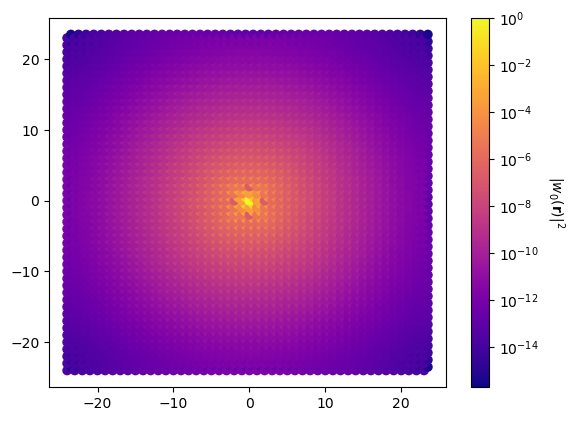

In [9]:
plot.plot_Wan_on_lat(w0, orbs, lat_vecs)